# Predicting selling price of houses
In this notebook, I will be using multiple datasets to predict the selling price of houses in Boston. Features are built from different datasets and are combined in the `../feature_engineering` directory. I will build the feature matrix progressively, starting from the most basic features. Then I will train the dataset using gradient boosting tree. Let's load the full feature dataframe.
 

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.metrics import r2_score
import warnings

warnings.filterwarnings('ignore')

property_type = 'townhouse'


df_features = pd.read_csv('../data/processed/' + 'Boston_%s_feature_matrix.csv'%property_type,index_col=0)
feature_names = df_features.columns
print(feature_names)


Index(['convenience', 'supermarket', 'park', 'school', 'station',
       'stop_position', 'LIST PRICE', 'SQUARE FEET', 'YEAR BUILT', 'BEDS',
       'BATHS', 'LOT SIZE', 'HOA/MONTH', 'EST $ TREND', 'REMARKS_1',
       'REMARKS_2', 'REMARKS_3', 'REMARKS_4', 'REMARKS_5', 'REMARKS_6',
       'REMARKS_7', 'REMARKS_8', 'REMARKS_9', 'REMARKS_10', 'SOLD PRICE',
       'SOLD DATE'],
      dtype='object')


First we use the real estate data: size, age, number of beds, baths, lot size and HOA/month to predict the selling price. The features are readily available from `../data/raw/redfin_2020-01-19-08-17-26.csv`, which is downloaded from `www.redfin.com`.

In [2]:
df_features.pop('LIST PRICE')

feature_real_estate = ['SQUARE FEET','YEAR BUILT','BEDS','BATHS','LOT SIZE','HOA/MONTH']

X = df_features[feature_real_estate].values
Y = df_features.pop('SOLD PRICE').values

N = len(X)
print('number of data: ',N)
Nfeature = len(feature_real_estate)
print('number of features: ',Nfeature)
train_size = int(0.7*N)

Xtrain = X[:train_size]
Xtest = X[train_size:]

Ytrain = Y[:train_size]
Ytest = Y[train_size:]

print('Xtrain.shape: ',Xtrain.shape)
print('Xtest.shape: ',Xtest.shape)
print('Ytrain.shape: ',Ytrain.shape)
print('Ytest.shape: ',Ytest.shape)




number of data:  545
number of features:  6
Xtrain.shape:  (381, 6)
Xtest.shape:  (164, 6)
Ytrain.shape:  (381,)
Ytest.shape:  (164,)


In [3]:
params = {'max_depth':[6,7,8,9,10],'n_estimators':[10,20,30,40,50],
          'learning_rate':[0.01,0.1,1]}

cv_scores = []
cv_scores_std = []
models = []

regr_cv = GridSearchCV(GradientBoostingRegressor(),
                       params,
                       cv=5)

print('training')
regr_cv.fit(Xtrain,Ytrain)

best_param = regr_cv.best_params_

regr_score = GradientBoostingRegressor(max_depth=best_param['max_depth'],
                                   n_estimators=best_param['n_estimators'])

cv_score = cross_val_score(regr_cv, Xtrain, Ytrain, cv=5)
print('regr score: %.3f +/- %.5f'%(np.mean(cv_score),np.std(cv_score)))
print('best param: ',regr_cv.best_params_)

cv_scores.append(np.mean(cv_score))
cv_scores_std.append(np.std(cv_score))
models.append(regr_cv)


training
regr score: 0.240 +/- 0.03549
best param:  {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 20}


The property price not only depends on the property itself but also the surronding amenities. Next we will include the geospatial data: e.g. how many convenience stores are there within 500m radius of a property? I gathered the data from an online query system called Overpass turbo and save the data in `.json`. The implementation can be found in `../feature_engineering/GetPOI.py`.

In [4]:
feature_geospatial = ['convenience','supermarket','park','school','station','stop_position']

feature_total = feature_real_estate + feature_geospatial
X = df_features[feature_total].values


N = len(X)
print('number of data: ',N)
Nfeature = len(feature_total)
print('number of features: ',Nfeature)
train_size = int(0.7*N)

Xtrain = X[:train_size]
Xtest = X[train_size:]

Ytrain = Y[:train_size]
Ytest = Y[train_size:]

print('Xtrain.shape: ',Xtrain.shape)
print('Xtest.shape: ',Xtest.shape)
print('Ytrain.shape: ',Ytrain.shape)
print('Ytest.shape: ',Ytest.shape)

number of data:  545
number of features:  12
Xtrain.shape:  (381, 12)
Xtest.shape:  (164, 12)
Ytrain.shape:  (381,)
Ytest.shape:  (164,)


In [5]:
regr_cv = GridSearchCV(GradientBoostingRegressor(),
                       params,
                       cv=5)

print('training')
regr_cv.fit(Xtrain,Ytrain)

best_param = regr_cv.best_params_

regr_score = GradientBoostingRegressor(max_depth=best_param['max_depth'],
                                   n_estimators=best_param['n_estimators'])

cv_score = cross_val_score(regr_cv, Xtrain, Ytrain, cv=5)
print('regr score: %.3f +/- %.5f'%(np.mean(cv_score),np.std(cv_score)))
print('best param: ',regr_cv.best_params_)

cv_scores.append(np.mean(cv_score))
cv_scores_std.append(np.std(cv_score))
models.append(regr_cv)

training
regr score: 0.407 +/- 0.09579
best param:  {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 30}


So far I have left out information about the interior of the property, e.g. is the basement/kitchen renovated? To incorporate this information, I will now include features derived from the broker's remarks. I first extracted ten topics using non-negative matrix factorization (NMF). Then I calculated, for each home, the similarity between each topic and the remark and thus generate a 10-dimensional feature for each house. The implementation can be found in `../feature_engineering/GetTopicVector.py`.

In [6]:
feature_remarks = ['REMARKS_%i'%(i+1) for i in range(10)]

feature_total = feature_real_estate + feature_geospatial + feature_remarks
X = df_features[feature_total].values


N = len(X)
print('number of data: ',N)
Nfeature = len(feature_total)
print('number of features: ',Nfeature)
train_size = int(0.7*N)

Xtrain = X[:train_size]
Xtest = X[train_size:]

Ytrain = Y[:train_size]
Ytest = Y[train_size:]

print('Xtrain.shape: ',Xtrain.shape)
print('Xtest.shape: ',Xtest.shape)
print('Ytrain.shape: ',Ytrain.shape)
print('Ytest.shape: ',Ytest.shape)

number of data:  545
number of features:  22
Xtrain.shape:  (381, 22)
Xtest.shape:  (164, 22)
Ytrain.shape:  (381,)
Ytest.shape:  (164,)


In [7]:
regr_cv = GridSearchCV(GradientBoostingRegressor(),
                       params,
                       cv=5)

print('training')
regr_cv.fit(Xtrain,Ytrain)

best_param = regr_cv.best_params_

regr_score = GradientBoostingRegressor(max_depth=best_param['max_depth'],
                                   n_estimators=best_param['n_estimators'])

cv_score = cross_val_score(regr_cv, Xtrain, Ytrain, cv=5)
print('regr score: %.3f +/- %.5f'%(np.mean(cv_score),np.std(cv_score)))
print('best param: ',regr_cv.best_params_)

cv_scores.append(np.mean(cv_score))
cv_scores_std.append(np.std(cv_score))
models.append(regr_cv)

training
regr score: 0.476 +/- 0.08511
best param:  {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 50}


As mentioned in `eda.ipynb`, the housing market trend is also a big factor in determining the selling price. For simplicity, I use the average price/sqft of properties sold in the last day as a proxy of the market trend. More sophisticated model such as LSTM can also be used to get a potentially more accurate prediction of the price/sqft trend. I have done some EDA on the price trend in `./lstm_eda.ipynb` to explore the feasibility of using LSTM to get a better estimation of the price trend.

In [8]:
feature_trend = ['EST $ TREND']

feature_total = feature_real_estate + feature_geospatial + feature_remarks + feature_trend
X = df_features[feature_total].values


N = len(X)
print('number of data: ',N)
Nfeature = len(feature_total)
print('number of features: ',Nfeature)
train_size = int(0.7*N)

Xtrain = X[:train_size]
Xtest = X[train_size:]

Ytrain = Y[:train_size]
Ytest = Y[train_size:]

print('Xtrain.shape: ',Xtrain.shape)
print('Xtest.shape: ',Xtest.shape)
print('Ytrain.shape: ',Ytrain.shape)
print('Ytest.shape: ',Ytest.shape)

number of data:  545
number of features:  23
Xtrain.shape:  (381, 23)
Xtest.shape:  (164, 23)
Ytrain.shape:  (381,)
Ytest.shape:  (164,)


In [9]:
regr_cv = GridSearchCV(GradientBoostingRegressor(),
                       params,
                       cv=5)

print('training')
regr_cv.fit(Xtrain,Ytrain)

best_param = regr_cv.best_params_

regr_score = GradientBoostingRegressor(max_depth=best_param['max_depth'],
                                   n_estimators=best_param['n_estimators'])

cv_score = cross_val_score(regr_cv, Xtrain, Ytrain, cv=5)
print('regr score: %.3f +/- %.5f'%(np.mean(cv_score),np.std(cv_score)))
print('best param: ',regr_cv.best_params_)

cv_scores.append(np.mean(cv_score))
cv_scores_std.append(np.std(cv_score))
models.append(regr_cv)

training
regr score: 0.453 +/- 0.08144
best param:  {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 50}


Finally, let's take a look at the improvements in the cross validation r2 scores due to the additions of each dataset

<IPython.core.display.Javascript object>


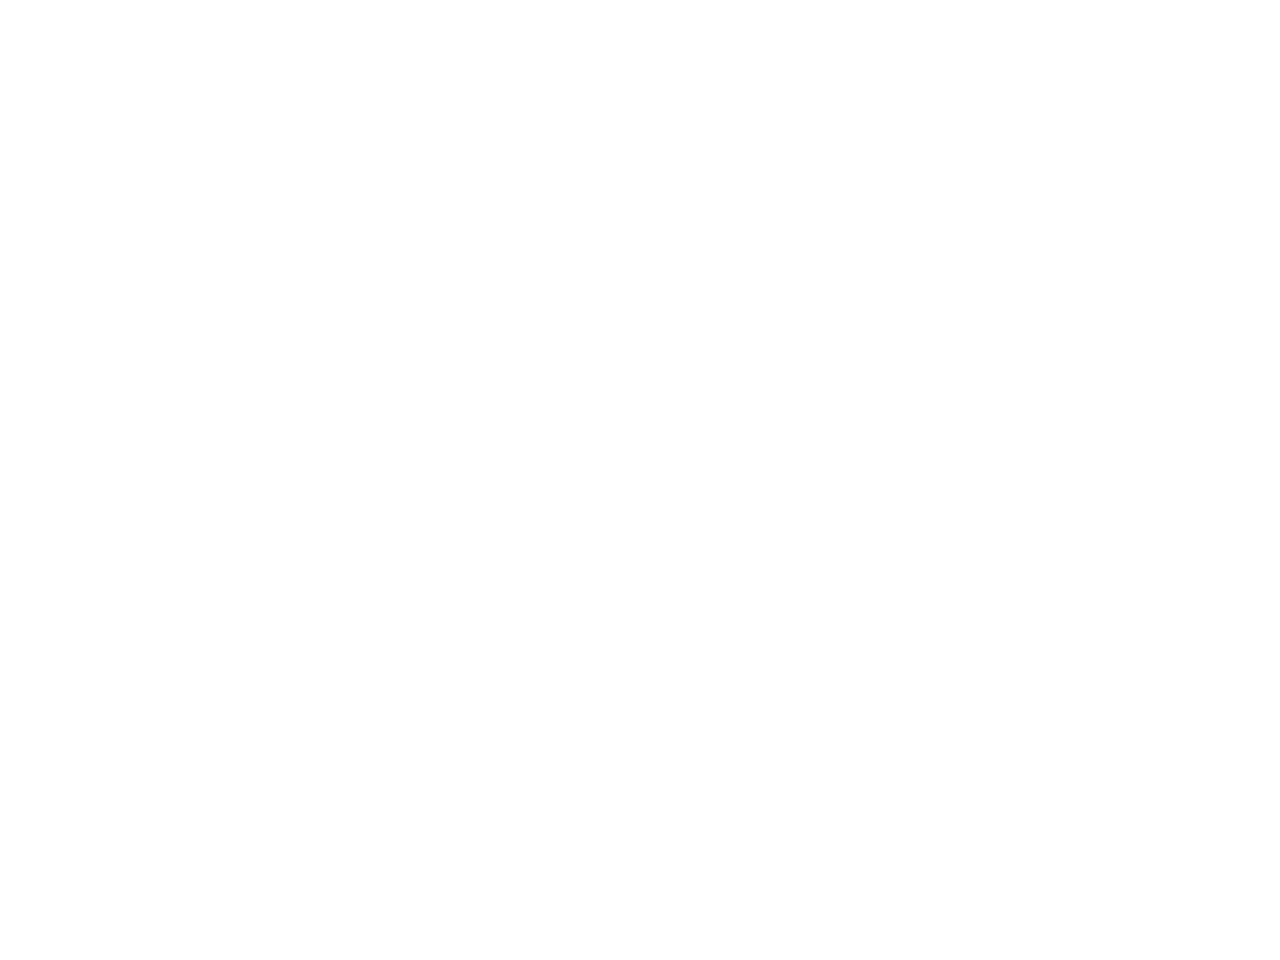

In [10]:
import matplotlib.pyplot as plt
%matplotlib notebook

import seaborn as sns

sns.set()

fig = plt.figure()
plt.plot(list(range(len(cv_scores))),cv_scores)
plt.ylim([0,1])
plt.xticks(list(range(len(cv_scores))),['basic real estate','geospatial','broker remarks','market trend'])
plt.ylabel('R2 score')
plt.show()

Let's look at how all different features contribute to predicting the selling price! I will start from the most naive, baseline method: using the average price/sqft from previous day to predict the selling price of the house.

# Testing performance

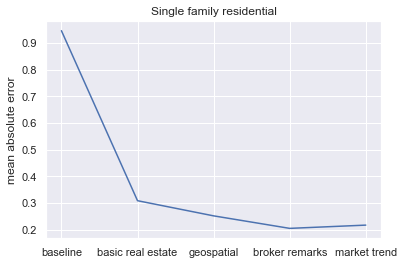

In [11]:
#feature_total = feature_real_estate + feature_geospatial + feature_remarks + feature_trend

MAEs = []

# baseline
Ypredict = df_features['EST $ TREND'].values
train_size = int(0.7*len(X))
Ypredict = Ypredict[train_size:]
Ytest = Y[train_size:]
MAEs.append(np.mean(np.abs(Ytest-Ypredict)/Ytest))

# add real estate data
feature_total = feature_real_estate
X = df_features[feature_total].values
train_size = int(0.7*len(X))
Xtest = X[train_size:]
Ytest = Y[train_size:]
Ypredict = models[0].predict(Xtest)
MAEs.append(np.mean(np.abs(Ytest-Ypredict)/Ytest))

# add geospatial features
feature_total = feature_real_estate + feature_geospatial
X = df_features[feature_total].values
train_size = int(0.7*len(X))
Xtest = X[train_size:]
Ytest = Y[train_size:]
Ypredict = models[1].predict(Xtest)
MAEs.append(np.mean(np.abs(Ytest-Ypredict)/Ytest))

# add brokers' remarks
feature_total = feature_real_estate + feature_geospatial + feature_remarks
X = df_features[feature_total].values
train_size = int(0.7*len(X))
Xtest = X[train_size:]
Ytest = Y[train_size:]
Ypredict = models[2].predict(Xtest)
MAEs.append(np.mean(np.abs(Ytest-Ypredict)/Ytest))

# add price trend
feature_total = feature_real_estate + feature_geospatial + feature_remarks + feature_trend
X = df_features[feature_total].values
train_size = int(0.7*len(X))
Xtest = X[train_size:]
Ytest = Y[train_size:]
Ypredict = models[3].predict(Xtest)
MAEs.append(np.mean(np.abs(Ytest-Ypredict)/Ytest))



fig = plt.figure()
plt.title('Single family residential')
plt.plot(list(range(len(MAEs))),MAEs)
#plt.ylim([0,0.4])
plt.xticks(list(range(len(MAEs))),['baseline','basic real estate','geospatial','broker remarks','market trend'])
plt.ylabel('mean absolute error')
plt.show()

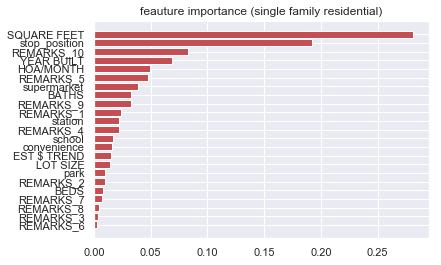

In [12]:
importances = models[3].best_estimator_.feature_importances_
#std = np.std([tree.feature_importances_ for tree in forest.estimators_],
#             axis=0)
indices = np.argsort(importances)[::1]


fig = plt.figure()
plt.title('feauture importance (single family residential)')
plt.barh(range(len(importances)), importances[indices],
       color="r", align="center")
plt.yticks(range(len(importances)), np.array(feature_total)[indices])
plt.show()

The size of the house is the most important feature to predicting the selling price. The second place is taken by a geospatial feature: how many bus stops there are within 500m of the house. The third place is taken by a textbased feature: how much is topic no.10 (e.g. is the kitchen renovated?). I expect that in general, there will be some overlapping in information provided by the broker's remark and the real estate/geospatial data. For example, in the remark, the broker might mention how close the property is to the bus station. However, I also expect some detail unique to the property can be indicative to the selling price of the house.

In [13]:
import pickle
for i in range(len(models)):
    with open('../pickled_models/RF_%s_%i.pkl'%(property_type,i),'wb') as f:
        pickle.dump(models[i],f) 

<IPython.core.display.Javascript object>


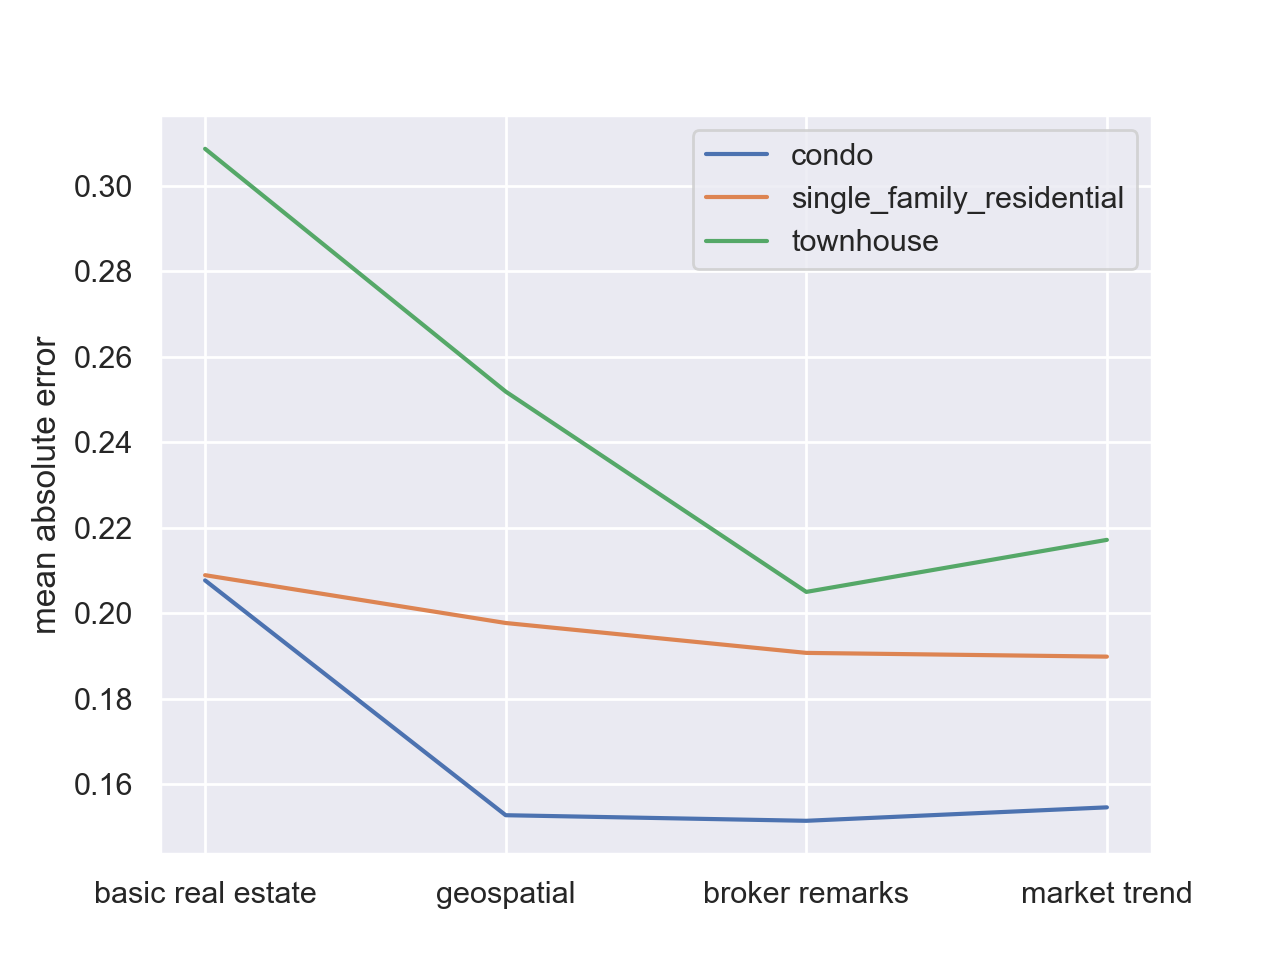

In [20]:
#feature_real_estate = ['SQUARE FEET','YEAR BUILT','BEDS','BATHS','LOT SIZE','HOA/MONTH']
features = []
features.append(feature_real_estate)
features.append(feature_real_estate + feature_geospatial)
features.append(feature_real_estate + feature_geospatial + feature_remarks)
features.append(feature_real_estate + feature_geospatial + feature_remarks + feature_trend)

fig = plt.figure()
for prop_type in ['condo','single_family_residential','townhouse']:
    MAEs = []
    for n in range(4): 
        model = pickle.load(open('../pickled_models/RF_%s_%i.pkl'%(prop_type,n), 'rb'))
        
        df_features = pd.read_csv('../data/processed/' + 'Boston_%s_feature_matrix.csv'%prop_type,index_col=0)
        feature_names = df_features.columns
        df_features.pop('LIST PRICE')

        X = df_features[features[n]].values
        Y = df_features.pop('SOLD PRICE').values

        train_size = int(0.7*len(X))
        Xtest = X[train_size:]
        Ytest = Y[train_size:]
        Ypredict = model.predict(Xtest)
        MAEs.append(np.mean(np.abs(Ytest-Ypredict)/Ytest))

    plt.plot(list(range(len(MAEs))),MAEs,label=prop_type)
    
plt.xticks(list(range(len(MAEs))),['basic real estate','geospatial','broker remarks','market trend'])
plt.legend(loc='best loc')
plt.ylabel('mean absolute error')
plt.show()

Comparing the performance of predicting selling price of different property types, we see that condo performs the best. Brokers' remarks provide more information about the selling price for townhouses than single family residentials and condos. Both townhouses and condos selling price depends more geospatial information than single family residentials. I suspect that condos and townhouses are usually in a more dense area with more amenities while single family residentials are usually in a more 